In [154]:
from sklearn.model_selection import KFold
import polars as pl
import numpy as np
from sklearn import preprocessing

TARGET = 'column_5'
CLUSTERS = 3

# Iris-setosa = 0
# Iris-versicolor = 1
# Iris-virginica = 2

def fetch_data(df, use_split):
    assert(use_split >= 0 and use_split <= 4)
    # perform 5-fold cross validation with a deterministic seed
    kf = KFold(n_splits=5, shuffle=True, random_state=2028)
    split_x, split_y = get_x_y(df)
    splits = list(kf.split(split_x, split_y))

    # indexing the dataframe with an array returns the appropriate splits
    df_train, df_test = df[splits[use_split][0]], df[splits[use_split][1]]
    return df_train, df_test

def get_x_y(df):
    encoder = preprocessing.LabelEncoder()
    X, y = df.drop(TARGET).to_numpy(), df.get_column(TARGET)
    y = np.array(encoder.fit(y).transform(y)) # encode categorical data
    return X, y

df = pl.read_csv('iris.data', has_header=False)
df_train, df_test = fetch_data(df, 0)
X_train, y_train = get_x_y(df_train)
X_test, y_test = get_x_y(df_test)
df_train.tail()

column_1,column_2,column_3,column_4,column_5
f64,f64,f64,f64,str
6.8,3.2,5.9,2.3,"""Iris-virginica..."
6.7,3.3,5.7,2.5,"""Iris-virginica..."
6.7,3.0,5.2,2.3,"""Iris-virginica..."
6.5,3.0,5.2,2.0,"""Iris-virginica..."
6.2,3.4,5.4,2.3,"""Iris-virginica..."


In [155]:
from sklearn.cluster import KMeans
import numpy as np

model = KMeans(n_clusters=3, random_state=2028, n_init='auto')
model.fit(X_train)

preds = model.predict(X_test)

np.count_nonzero(preds == y_test) / len(y_test)

0.8666666666666667

In [156]:
import numpy as np
import random

def euclidean(p1, p2):
    return np.sqrt(np.sum((p1 - p2)**2, axis=1))

# for each point, find the closest centroid & assign to a cluster
def assign_clusters(X, centroids):
    return [np.argmin(euclidean(x, centroids)) for x in X]
    
# update the centroids
def update_centroids(X, clusters):
    centroids = []

    for c in set(clusters):
        cluster = X[np.where(clusters == c)[0]]
        mean = cluster.mean(axis=0)
        centroids.append(mean)
    return centroids

class KMeans():
    def __init__(self, n_clusters, epochs=300):
        self.n_clusters = n_clusters
        self.epochs = epochs
        self.centroids = []

    def fit(self, X):
        # randomly initialize centroids. todo: make replicable
        centroids = [x for x in random.sample(X.tolist(), self.n_clusters)]

        for _ in range(self.n_clusters):
            distances = np.sum([euclidean(X_train, centroid) for centroid in centroids], axis=0)            
            distances /= np.sum(distances) # normalize

            # choose centroids probabilistically 
            centroid_idx = np.random.choice(range(len(X_train)), size=1, p=distances)[0]
            self.centroids += [X_train[centroid_idx]]

        for _ in range(self.epochs):
            self.clusters = assign_clusters(X, self.centroids)
            self.centroids = update_centroids(X, self.clusters)
    
    def predict(self, X):
        return assign_clusters(X, self.centroids)

model = KMeans(n_clusters=3) 
model.fit(X_train)

preds = model.predict(X_test)
np.count_nonzero(preds == y_test) / len(y_test)

0.8666666666666667

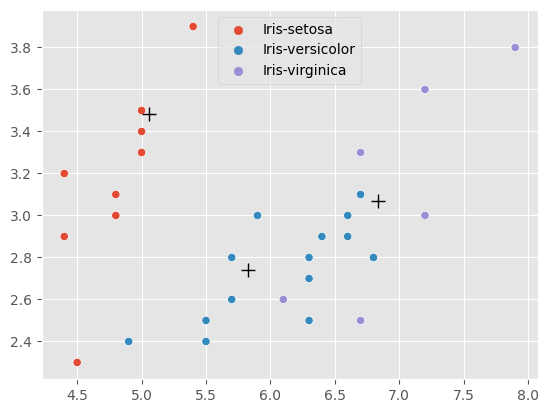

In [159]:
import seaborn 
import matplotlib.pyplot as plt

plt.style.use('ggplot')
COLORS = seaborn.color_palette()

plt.figure()
ax = seaborn.scatterplot(x=[X[0] for X in X_test],
                y=[X[1] for X in X_test],
                hue=preds,
                palette=COLORS[0:3],
                legend='full'
                )
plt.plot([x for x, _, _, _ in model.centroids],
         [y for _, y, _, _ in model.centroids],
         '+',
         markersize=10,
         c='black',
         )
h, _ = ax.get_legend_handles_labels()
plt.legend(handles=h, loc='upper center', labels=['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'])
plt.show()